In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [2]:
prod_ind=pd.read_excel("C:\\Users\\Francis\\Desktop\\Data_science\\semester_3\\Workshop_Static\\data_Osei.xlsx")
prod_ind = prod_ind.iloc[2:]
prod_ind = prod_ind[['Time', 'Economic Activity, Industrial Production']]
prod_ind['Time'] = pd.to_datetime(prod_ind['Time'])
prod_ind = prod_ind.rename(columns={'Economic Activity, Industrial Production': 'Production index'})
prod_ind = prod_ind.reset_index(drop=True)
prod_ind.head()

,Time,Production index
0,2015-01-01,96.71
1,2015-02-01,97.84
2,2015-03-01,108.54
3,2015-04-01,103.29
4,2015-05-01,101.33


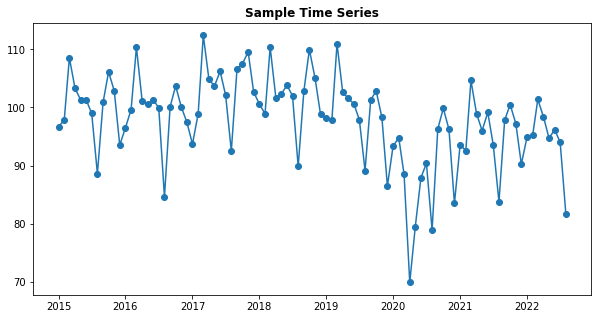

In [3]:
index_date = prod_ind['Time']
index_value = prod_ind['Production index']
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
plt.plot_date(index_date, index_value, linestyle='solid')
plt.title('Sample Time Series', fontweight ="bold")
plt.show()

# Question 1

Decide/describe if the series is stationary or not. Support your argument with AC&PAC functions and by means of statistical tests. Explain which transformation you will use to render the series
stationary and ready for modelling.

Checking for stationarity using Augmented Dickey-Fuller Test. If a time series exhibits no trend, constant variance over time, and constant autocorrelation over time, it is said to be stationary.  The Augmented Dickey-Fuller Test try solve the hypothesis

H_0: The series is non-stationary.The series has some time-dependent structure and does not have constant variance over time.

H_1: The series is stationary.

If the p-value from the test is less than some significance level (here we take α = 0.05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [4]:
adfuller_test1 = adfuller(prod_ind['Production index'], autolag='AIC')
adfuller_output1 = pd.Series(adfuller_test1[0:3], index=['ADF Statistic','p-value','#Lags Used'])
for key,value in adfuller_test1[4].items():
    adfuller_output1['Critical Value (%s)'%key] = value
print (adfuller_output1)

ADF Statistic           -1.698324
p-value                  0.431976
#Lags Used              12.000000
Critical Value (1%)     -3.515977
Critical Value (5%)     -2.898886
Critical Value (10%)    -2.586694
dtype: float64


From the p-value = 0.43 > α = 0.05 , we can say that our series is non stationary. We will proceed futher by using the differencing method.

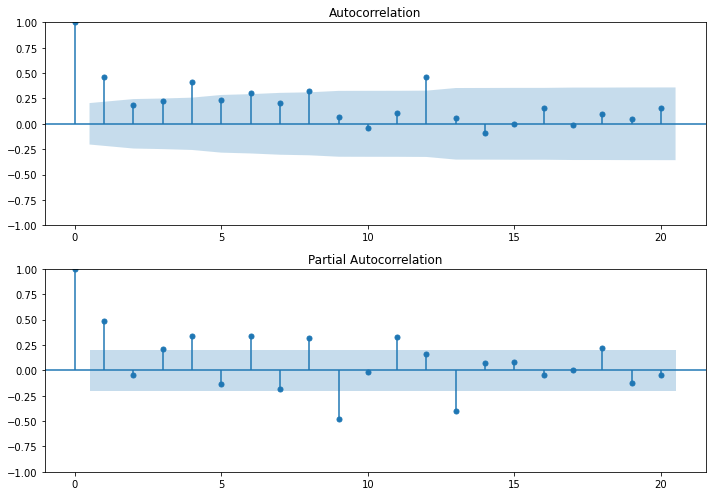

In [5]:
f, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 7))
plot_acf(prod_ind['Production index'],lags = 20, ax = ax[0])
plot_pacf(prod_ind['Production index'],lags = 20, ax = ax[1], method = 'ols')  
plt.tight_layout()
plt.show()

Checking for stationarity after taken the difference. The purpose of differencing is to remove any trends or seasonal  from our series.  we check for stationarity for the first diference and check again for the second time.

# First Differencing

In [6]:
prod_ind['Production index_diff1'] = prod_ind['Production index'].diff().fillna(0)
prod_ind.head(5)

,Time,Production index,Production index_diff1
0,2015-01-01,96.71,0.00
1,2015-02-01,97.84,1.13
2,2015-03-01,108.54,10.70
3,2015-04-01,103.29,-5.25
4,2015-05-01,101.33,-1.96


Stationarity check for the first difference

In [7]:
adfuller_test2 = adfuller(prod_ind['Production index_diff1'], autolag='AIC')
adfuller_output2 = pd.Series(adfuller_test2[0:3], index=['ADF Statistic','p-value','#Lags Used'])
for key,value in adfuller_test2[4].items():
    adfuller_output2['Critical Value (%s)'%key] = value
print(adfuller_output2)

ADF Statistic           -2.608603
p-value                  0.091232
#Lags Used              11.000000
Critical Value (1%)     -3.514869
Critical Value (5%)     -2.898409
Critical Value (10%)    -2.586439
dtype: float64


From the p-value = 0.09 > α = 0.05 , we can say that our series is non stationary. We will proceed futher by using the differencing method again.

# Second differencing

In [8]:
prod_ind['Production index_diff2'] = prod_ind['Production index_diff1'].diff().fillna(0)
prod_ind.head(5)

,Time,Production index,Production index_diff1,Production index_diff2
0,2015-01-01,96.71,0.00,0.00
1,2015-02-01,97.84,1.13,1.13
2,2015-03-01,108.54,10.70,9.57
3,2015-04-01,103.29,-5.25,-15.95
4,2015-05-01,101.33,-1.96,3.29


In [9]:
adfuller_test2 = adfuller(prod_ind['Production index_diff2'], autolag='AIC')
adfuller_output2 = pd.Series(adfuller_test2[0:3], index=['ADF Statistic','p-value','#Lags Used'])
for key,value in adfuller_test2[4].items():
    adfuller_output2['Critical Value (%s)'%key] = value
print (adfuller_output2)

ADF Statistic          -5.906603e+00
p-value                 2.699403e-07
#Lags Used              1.000000e+01
Critical Value (1%)    -3.513790e+00
Critical Value (5%)    -2.897943e+00
Critical Value (10%)   -2.586191e+00
dtype: float64


We can observe a p-value less that 0.05 indicating stationarity in the our series. The more negative ADF Statistic, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence. From the previous ADF Statistic we can observe that the the second difference as the smallest ADF Statistic value. We can also observe that ADF Statistic has values compred to our criticl values which also indicate how strong we can reject our null hypothesis.

In [10]:
kpss_test = kpss(prod_ind['Production index_diff2'], regression='c', nlags="auto")
kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpss_test[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic            0.184358
p-value                   0.100000
#Lags Used               26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Francis\anaconda3\envs\rstudio\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


The KPSS test works differently from the ADF interms of the hypothesis formulation. The KPSS solve the hypothesis

H_0: The series is stationary

H_1: The series is non-stationary.

The hypothesis Test Statistic < Critical Value and p-value > 0.05. As a result, we don not have enough evidence to reject the Null hypothesis in favor of an Alternative.

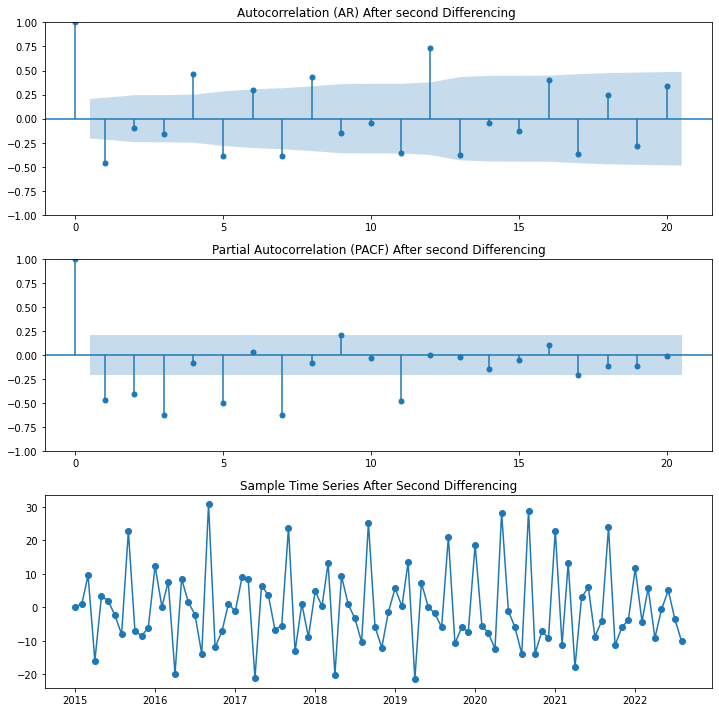

In [11]:
f, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 10))
plt.plot_date(index_date, prod_ind['Production index_diff2'], linestyle='solid')
plt.title('Sample Time Series After Second Differencing')
plot_acf(prod_ind['Production index_diff2'],lags = 20, ax = ax[0],title='Autocorrelation (AR) After second Differencing ')
plot_pacf(prod_ind['Production index_diff2'],lags = 20, ax = ax[1], method = 'ols',title='Partial Autocorrelation (PACF) After second Differencing')  
plt.tight_layout()
plt.show()

# Question 2

Take stationary series (from step 1), reserve the first 80% of the sample for estimation and
select an appropriate ARIMA model. Justify your choice.

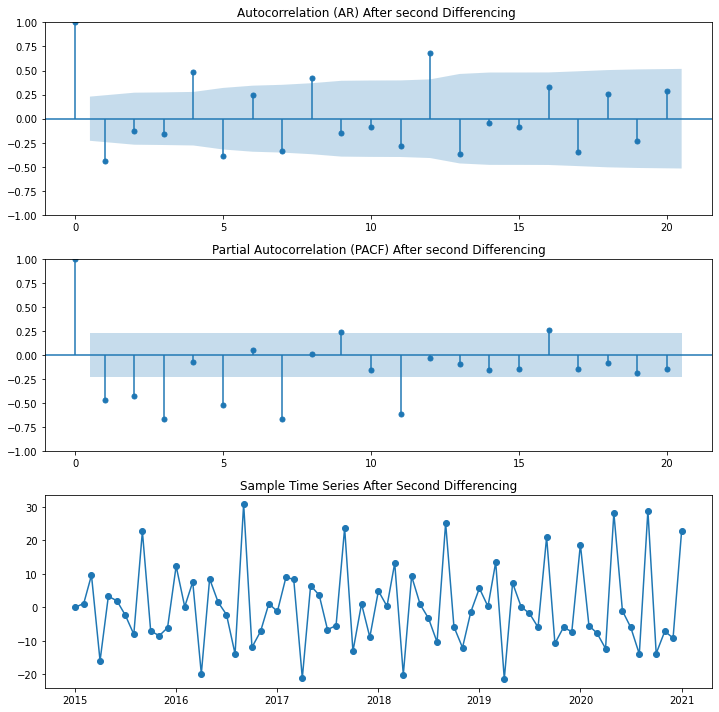

In [12]:
num_samples = len(prod_ind)
train_len = int(0.8* len(prod_ind))
f, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 10))
plt.plot_date(index_date[:train_len], prod_ind['Production index_diff2'][:train_len], linestyle='solid')
plt.title('Sample Time Series After Second Differencing')
plot_acf(prod_ind['Production index_diff2'][:train_len],lags = 20, ax = ax[0],title='Autocorrelation (AR) After second Differencing ')
plot_pacf(prod_ind['Production index_diff2'][:train_len],lags = 20, ax = ax[1], method = 'ols',title='Partial Autocorrelation (PACF) After second Differencing')  
plt.tight_layout()
plt.show()

from the plot above, the PACF plot has significant spikes at lags 1, 2 and 3 because of the significant PACF value. We canchoose AR(p) where p=3. Again we can observe that spikes higher than the blue area in the AR plot can be detected in lag 1. Thus we can have MA(1). Combining the two observation, ARIMA(3,2,1) is our prefered model. We can also oserve that, there are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

In [13]:
train = prod_ind['Production index_diff2'].iloc[:train_len]
test = prod_ind['Production index_diff2'].iloc[train_len:num_samples]
arma_model = ARIMA(train, order=(3,2,1)).fit()
print(arma_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Production index_diff2   No. Observations:                   73
Model:                     ARIMA(3, 2, 1)   Log Likelihood                -271.845
Date:                    Sat, 31 Dec 2022   AIC                            553.689
Time:                            10:39:16   BIC                            565.003
Sample:                                 0   HQIC                           558.188
                                     - 73                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1595      0.110    -10.589      0.000      -1.374      -0.945
ar.L2         -1.0342      0.119     -8.678      0.000      -1.268      -0.801
ar.L3         -0.733

In [14]:
np.mean(arma_model.resid)

-0.054681884317188276

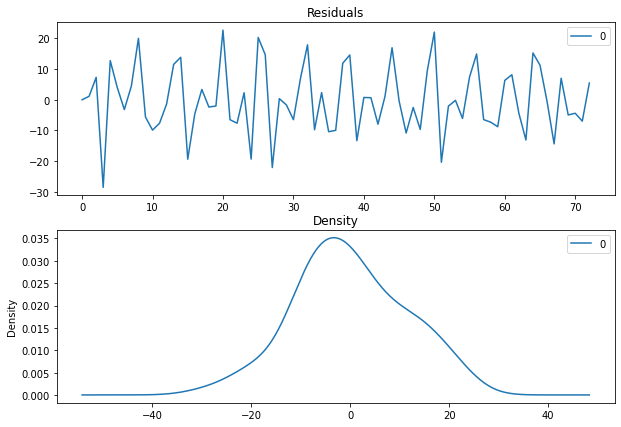

In [15]:
residuals = pd.DataFrame(arma_model.resid)
f, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 7))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

We can see from from the density is almost normally distributed around mean with an approximate value around 0.

# Question 3

Use the model (from step 2) and perform 1-step-ahead forecasts for your series for the remaining 20% of the sample. Plot the forecasts and the true values. Report also RMSE of the
forecasts

In [16]:
arma_model_new = ARIMA(train, order=(3,2,1)).fit()
forecasts = {}
forecasts[train.index[-1]] =  arma_model_new.forecast(steps=1)
for t in range(train_len, num_samples):
    updated_endog = prod_ind['Production index_diff2'].iloc[t:t+1]
    arma_model_new = arma_model_new.extend(updated_endog)
    forecasts[updated_endog.index[0]] =  arma_model_new.forecast(steps=1)

forecasts = pd.concat(forecasts, axis=1)

C:\Users\Francis\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


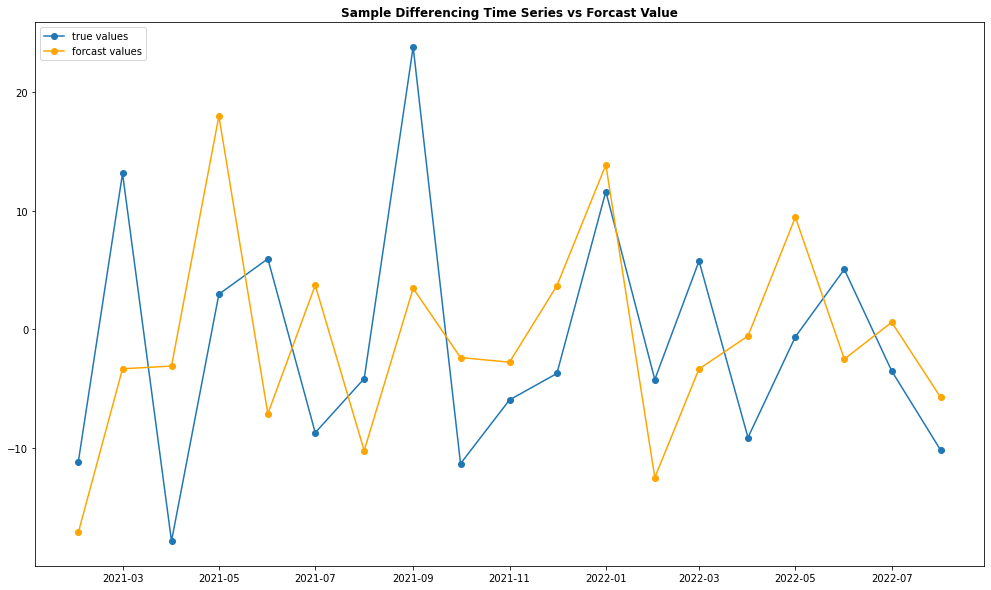

<Figure size 432x288 with 0 Axes>

In [17]:
test_data = pd.DataFrame(prod_ind[train_len:num_samples])
index_date1 = test_data['Time']
array_forcast = forecasts.values[[np.arange(forecasts.shape[0])]*2]
array_forcast = array_forcast[:-1]
test_data['forcast'] =array_forcast.tolist()
plt.figure(figsize=(17,10))
plt.plot_date(index_date[train_len:num_samples], prod_ind['Production index_diff2'][train_len:num_samples], linestyle='solid',label="true values")
plt.plot_date(index_date1, test_data['forcast'], linestyle='solid',color='orange',label="forcast values")
plt.title('Sample Differencing Time Series vs Forcast Value', fontweight ="bold")
plt.legend(loc="upper left")
plt.show()
plt.tight_layout()
plt.show()

In [18]:
forecast_errors = forecasts.apply(lambda column: prod_ind['Production index_diff2'] - column).reindex(forecasts.index)
def flatten(column):
    return column.dropna().reset_index(drop=True)
flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('RMSE')
rmse = (flattened**2).mean(axis=1)**0.5
print(rmse)

RMSE
1    10.503601
dtype: float64


# Outlier detection using Isolated forest

Isolation Forest recognizes anomalies solely on the basis of the fact that anomalies are made up of a small number of distinct data points. Anomalies are isolated without using any density or distance measurements.

In [19]:
new_train = prod_ind.iloc[:train_len]
df_train = pd.DataFrame(new_train, columns=["Time","Production index_diff2"])

In [20]:
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_train['Production index_diff2'].values.reshape(-1, 1))
data_scaled = pd.DataFrame(np_scaled)
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data_scaled) 

IsolationForest(contamination=0.01)

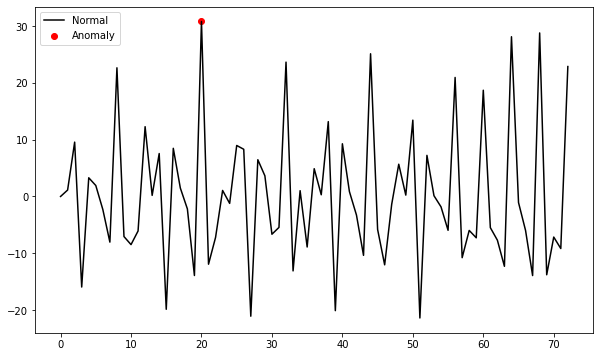

In [21]:
#Plotting the annomaly for the train data
df_train['anomaly'] = model.predict(data_scaled)
fig, ax = plt.subplots(figsize=(10,6))
a = df_train.loc[df_train['anomaly'] == -1, ['Production index_diff2']] #anomaly
ax.plot(df_train.index, df_train['Production index_diff2'], color='black', label = 'Normal')
ax.scatter(a.index,a['Production index_diff2'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [22]:
# We build the ARIMA(p,d,q) on the new training data
rows_drop = df_train[df_train['anomaly'] == -1]
prod_ind_outlier = prod_ind.drop(rows_drop.index).reset_index()
new_train = df_train.drop(rows_drop.index).reset_index()
arma_model_outlier = ARIMA(new_train['Production index_diff2'], order=(3,2,1)).fit()
print(arma_model_outlier.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Production index_diff2   No. Observations:                   72
Model:                     ARIMA(3, 2, 1)   Log Likelihood                -266.988
Date:                    Sat, 31 Dec 2022   AIC                            543.976
Time:                            10:39:23   BIC                            555.218
Sample:                                 0   HQIC                           548.442
                                     - 72                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0848      0.113     -9.635      0.000      -1.306      -0.864
ar.L2         -0.9554      0.125     -7.615      0.000      -1.201      -0.710
ar.L3         -0.725

C:\Users\Francis\anaconda3\envs\rstudio\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Computing new RMSE

In [23]:
len_new = len(new_train)
arma_model_outlier = ARIMA(new_train['Production index_diff2'], order=(3,2,1)).fit()
forecasts2 = {}
forecasts2[new_train.index[-1]] =  arma_model_outlier.forecast(steps=1)
for t in range(len_new, num_samples-len(rows_drop)):
    updated_endog1 = prod_ind_outlier['Production index_diff2'].iloc[t:t+1]
    arma_model_outlier = arma_model_outlier.extend(updated_endog1)
    forecasts2[updated_endog1.index[0]] =  arma_model_outlier.forecast(steps=1)
forecasts2 = pd.concat(forecasts2, axis=1)
forecast_errors2 = forecasts2.apply(lambda column: prod_ind_outlier['Production index_diff2'] - column).reindex(forecasts2.index)
def flatten(column):
    return column.dropna().reset_index(drop=True)
flattened2 = forecast_errors2.apply(flatten)
flattened2.index = (flattened2.index + 1).rename('RMSE')
rmse = (flattened2**2).mean(axis=1)**0.5
print(rmse)

C:\Users\Francis\anaconda3\envs\rstudio\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE
1    10.609332
dtype: float64


We can observe that the RMSE increases after taken out the outlier. Removing outliers help you make the numerical results look better, but it does not help to improve the accuracy of our forecast.